# I - Theoretical Calculations

We have the following Hamiltonian for the circuit : 

$$
H = \frac {C_T} 2 \dot{{\phi_T}}^2 + \frac {C_R} 2 \dot{{\phi_R}}^2 + \frac {C_C} 2 (\dot{{\phi_T}} -\dot{{\phi_R}})^2 + \frac 1 {2L}{\phi_R}^2 - E_J \cos\bigg(\frac {\phi_T} {\phi_0}\bigg)
$$

With $\phi_0 = \frac \hbar {2e}$, and the variables indexed by $T$ represent the Transmon part of the circuits, the ones indexed by $R$ the Resonator ones, and by $C$ the Coupling ones.

We have the following capacitance matrix :
$$
\mathcal{C} =
\begin{pmatrix}
C_T + C_C & C_C \\
C_C & C_R + C_C
\end{pmatrix}
$$

This leads us to define :
$$E_{C_T} := \frac {e^2} {2(C_T+C_C)}$$
$$E_{C_R} := \frac {e^2} {2(C_R+C_C)}$$
$$E_{L} := \frac {{\phi_0}^2} {2L}$$

And :

$$
\begin{align}
n_T := \frac 1 {2e} (C_T + C_C) \dot{\phi}_T \;\;\; &; \;\;\; \varphi_T := \frac {\phi_T} {\phi_0}\\
n_R := \frac 1 {2e} (C_R + C_C) \dot{\phi}_R \;\;\; &; \;\;\; \varphi_R := \frac {\phi_R} {\phi_0}
\end{align}
$$
$$$$

$$$$

This leads to :
$$
\begin{align}
H = & \ 4E_{C_T}{n_T}^2 - E_J \cos(\varphi_T) \\
&+ 4E_{C_R}{n_R}^2 + \frac {E_L} 2 \varphi_R \\ 
& -4e^2 \frac{C_C}{C_T C_R} n_T n_R
\end{align}
$$

i.e.

$$
\begin{align}
H = & \ H_T \\
&+ H_R \\ 
&+ H_C
\end{align}
$$

Let's define the coupling energy :
$$E_{coupling} := e^2 \frac{C_C}{C_T C_R}$$

Finally, let's write this Hamiltonian as an operator. We get:

$$
\begin{align}
\hat H = & \ \bigg[4E_{C_T}{\hat n_T}^2 - E_J \cos(\hat\varphi_T)\bigg] \otimes {\mathbb{I}} \\
&+ \mathbb{I} \otimes \bigg[4E_{C_R}{\hat n_R}^2 + \frac {E_L} 2 \hat\varphi_R^2\bigg] \\ 
& -4E_{coupling} \ \hat n_T \otimes \hat n_R
\end{align}
$$

And if we recall that $\hat n_R = \frac{\hat a - \hat a^{\dagger}} {2i\varphi_{ZPF}}$
where $\varphi_{ZPF} = \bigg(\frac {2E_C} {E_L} \bigg)^{\frac 1 4}$, we get the expression of $\hat H$ using the creation and destruction operators, and the charge operators only, meaning :

$$
\begin{align}
\hat H = & \ \bigg[4E_{C_T}{\hat n_T}^2 - E_J \cos(\hat\varphi_T)\bigg] \otimes {\mathbb{I}} \\
&+ \mathbb{I} \otimes \left(\hbar \omega (\hat a^{\dagger} \hat a) + \frac 1 2\right) \\ 
& -4E_{coupling} \ \hat n_T \otimes \left(\frac{\hat a - \hat a^{\dagger}} {2i\varphi_{ZPF}}\right)
\end{align}
$$

# II - Implementation using SCQubits

In [107]:
import scqubits as sc
import numpy as np

In [108]:
def translate(L): return L-L[0] #changes all values by the first value of the list

In [109]:
def eigenvalues_sc(ECT, ECR, ECoup, EJ, EL, transmon_trunc=31, resonator_trunc=20):

    transmon = sc.Transmon(
        EJ=EJ,
        EC=ECT,
        ng=0.0,
        ncut=transmon_trunc,
        truncated_dim=4
    )

    resonator = sc.Oscillator(
        E_osc=np.sqrt(8*ECR*EL),
    )

    hilbertspace = sc.HilbertSpace([transmon, resonator])

    phizpf = ((2*ECR) / EL) ** (1 / 4)

    n_resonator = (resonator.annihilation_operator() - resonator.creation_operator()) / (2j * phizpf)

    hilbertspace.add_interaction(
        g=-4*ECoup,
        op1=(transmon.n_operator, transmon),
        op2=(n_resonator, resonator)
    )

    return hilbertspace.eigensys(evals_count=4)[0]

In [128]:
evals_sc = translate(eigenvalues_sc(2.5, 2.5, 0.3, 5, 1))

# III - Implementation using QuTiP

In [111]:
import qutip as qt

In [112]:
def hamiltonian_qt(ECT, ECR, ECoup, EJ, EL, transmon_trunc=31, resonator_trunc=40) :

    ## Transmon Hamiltonian
    charge = qt.charge(transmon_trunc//2, -transmon_trunc//2)
    cos_phi = qt.tunneling(2 * transmon_trunc//2 + 1)

    HT = 4 * ECT * charge * charge - EJ / 2 * cos_phi

    ## Resonator Hamiltonian
    creation = qt.create(resonator_trunc)  # Creation and destruction operators
    destruction = qt.destroy(resonator_trunc)

    HR = (
        np.sqrt(8 * ECR * EL) * (creation * destruction + 1 / 2)
    )

    ## Coupling Hamiltonian

    phizpf = ((2*ECR) / EL) ** (1 / 4)
    n_R = (destruction - creation) / (2j * phizpf)

    HC = -4*ECoup * qt.tensor(charge,n_R)


    ## Final Hamiltonian :
    return qt.tensor(HT, qt.qeye(resonator_trunc)) + qt.tensor(qt.qeye(2 * transmon_trunc//2 + 1),HR) + HC

In [123]:
evals_qt = translate(hamiltonian_qt(2.5, 2.5, 0.3, 5, 1).eigenenergies())[:4]

# IV - Implementation using Numpy

In [114]:
import numpy.linalg as alg

In [115]:
def hamiltonian_np(ECT, ECR, ECoup, EJ, EL, transmon_trunc=31, resonator_trunc=40):

    ## Transmon Hamiltonian

    dim_transmon = 2*transmon_trunc//2 + 1
    charge = np.zeros((dim_transmon, dim_transmon))
    cos_phi = np.zeros((dim_transmon, dim_transmon))

    for i in range(dim_transmon-1):
        cos_phi[i, i + 1] = 1
        cos_phi[i + 1, i] = 1
        charge[i, i] = i - dim_transmon//2

    charge[-1, -1] = dim_transmon//2

    HT = 4 * ECT * charge**2 - EJ / 2 * cos_phi


    ## Resonator Hamiltonian

    destruction = np.zeros((resonator_trunc, resonator_trunc))

    for n in range(1, resonator_trunc):
        destruction[n - 1, n] = np.sqrt(n)

    creation = destruction.T 

    HR =  np.sqrt(8 * ECR * EL) * (
        np.dot(creation, destruction) + np.eye(resonator_trunc) * (1 / 2)
    )


    ## Coupling Hamiltonian

    phizpf = ((2*ECR) / EL) ** (1 / 4)
    n_R = (destruction - creation) / (2j * phizpf)

    HC = -4*ECoup * np.kron(charge,n_R)


    ## Final Hamiltonian

    return np.kron(HT, np.eye(resonator_trunc)) + np.kron(np.eye(dim_transmon), HR) + HC



In [136]:
evals_np = translate(np.sort(alg.eigvals(hamiltonian_np(2.5, 2.5, 0.3, 5, 2, resonator_trunc=6))))[:4]

In [137]:
print(evals_sc,'\n', evals_qt,'\n', evals_qt)

[ 0.          4.46875632  8.93746211 10.90738833] 
 [ 0.          4.46875627  8.9374619  10.90735693] 
 [ 0.          4.46875627  8.9374619  10.90735693]


# V - Comparaison

In [118]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [140]:
def compute_energies(
    ECT, ECR, ECoup, EJ, start_EL=1, end_ECT=30, nbpoints=50, transmon_trunc=31, resonator_trunc=6, nblevels = 6
):
    EL_list = np.linspace(start_EL, end_ECT, nbpoints)
    Energies = np.empty((3, nblevels, EL_list.size))
    
    for i, EL in enumerate(EL_list):
        
        Energies[0, :, i] = translate(np.sort(alg.eigvals(hamiltonian_np(ECT,ECR,ECoup,EJ,EL, transmon_trunc=transmon_trunc, resonator_trunc=resonator_trunc))))[:nblevels]
        
        Energies[1, :, i] = translate(hamiltonian_qt(ECT,ECR,ECoup,EJ,EL, transmon_trunc=transmon_trunc, resonator_trunc=resonator_trunc).eigenenergies())[:nblevels]
        
        Energies[2, :, i] = translate(eigenvalues_sc(ECT,ECR,ECoup,EJ,EL, transmon_trunc=transmon_trunc, resonator_trunc=resonator_trunc))[:nblevels]
        
    return EL_list, Energies

 C:\Users\VANDERSIPPE\AppData\Local\Temp\ipykernel_1476\1652735272.py: 9

[Text(0.5, 1.0, '4 first energy levels calculated using 3 different solvers'),
 Text(0.5, 0, 'Readout Inductance Energy'),
 Text(0, 0.5, 'Energy [GHz]')]

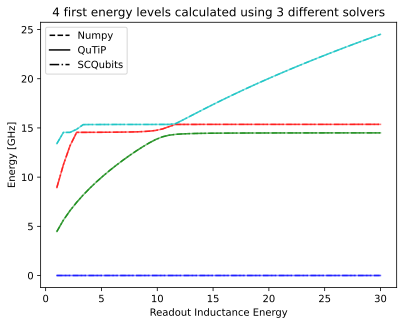

In [150]:
nblevels = 4

ECT_list, Energies = compute_energies(3.5, 2.5, 0.7, 5, nblevels=nblevels)

Colors = ["b", "g", "r", "c", "m", "y"]

fig, ax = plt.subplots()

for i in range(nblevels):
    ax.plot(ECT_list, Energies[0, i, :], linestyle="--", c=Colors[i], alpha=0.5)
    ax.plot(ECT_list, Energies[1, i, :], linestyle="-", c=Colors[i], alpha=0.5)
    ax.plot(ECT_list, Energies[2, i, :], linestyle="-.", c=Colors[i], alpha=0.5)


ax.legend(
    handles=[
        mlines.Line2D([], [], color="black", linestyle="--", label="Numpy"),
        mlines.Line2D([], [], color="black", linestyle="-", label="QuTiP"),
        mlines.Line2D([], [], color="black", linestyle="-.", label="SCQubits"),
    ]
)

ax.set(title=f"{nblevels} first energy levels calculated using 3 different solvers", 
       xlabel= "Readout Inductance Energy", 
       ylabel = "Energy [GHz]")